In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az # For visualization and loo
#needed for notebook
import nest_asyncio
nest_asyncio.apply()

## Data

In [2]:
df=pd.read_csv('data/erakondaded_rahastamine.csv')
df.shape

(127386, 8)

In [3]:
df.head()

,laekumise_aeg,tululiik,nimi,sünnikuupäev_regkood,summa,periood_erakond,aruande_periood,erakond
0,25.06.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei
1,21.03.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei
2,06.06.2017,Liikmemaks,TÕNIS TULP,20.07.1951,25,10.07.2017 Eesti Iseseisvuspartei,10.07.2017,Eesti Iseseisvuspartei
3,09.01.2017,Rahaline annetus,KARL MARTINSON,30.06.1979,30,13.04.2017 Eesti Iseseisvuspartei,13.04.2017,Eesti Iseseisvuspartei
4,24.03.2016,Rahaline annetus,KARL MARTINSON,30.06.1979,20,11.04.2016 Eesti Iseseisvuspartei,11.04.2016,Eesti Iseseisvuspartei


<Axes: >

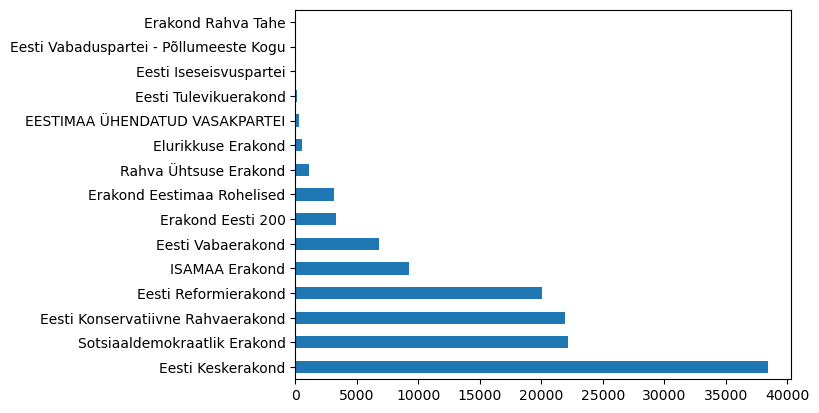

In [6]:
df.erakond.value_counts().plot(kind='barh')

<Axes: ylabel='erakond'>

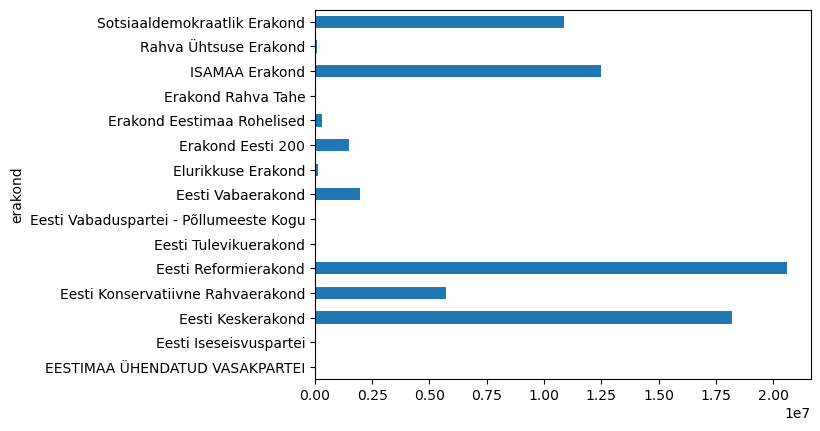

In [47]:
df.groupby('erakond')['summa'].sum().plot(kind='barh')

## Extact dates

In [8]:
df['laekumise_aeg_dt']=pd.to_datetime(df.laekumise_aeg)

/tmp/ipykernel_317/545875471.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['laekumise_aeg_dt']=pd.to_datetime(df.laekumise_aeg)


In [9]:
df.head()

,laekumise_aeg,tululiik,nimi,sünnikuupäev_regkood,summa,periood_erakond,aruande_periood,erakond,laekumise_aeg_dt
0,25.06.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei,2018-06-25
1,21.03.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei,2018-03-21
2,06.06.2017,Liikmemaks,TÕNIS TULP,20.07.1951,25,10.07.2017 Eesti Iseseisvuspartei,10.07.2017,Eesti Iseseisvuspartei,2017-06-06
3,09.01.2017,Rahaline annetus,KARL MARTINSON,30.06.1979,30,13.04.2017 Eesti Iseseisvuspartei,13.04.2017,Eesti Iseseisvuspartei,2017-09-01
4,24.03.2016,Rahaline annetus,KARL MARTINSON,30.06.1979,20,11.04.2016 Eesti Iseseisvuspartei,11.04.2016,Eesti Iseseisvuspartei,2016-03-24


## Plot some dynamics

<Axes: xlabel='laekumise_aeg_dt'>

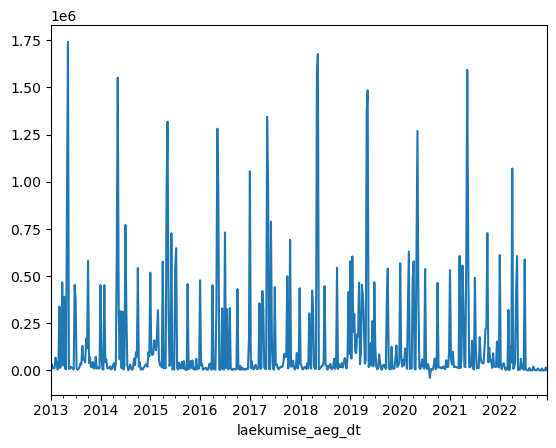

In [15]:
#daily sums
df.set_index('laekumise_aeg_dt').groupby(pd.Grouper(freq='W'))['summa'].sum().plot()

<Axes: xlabel='laekumise_aeg_dt'>

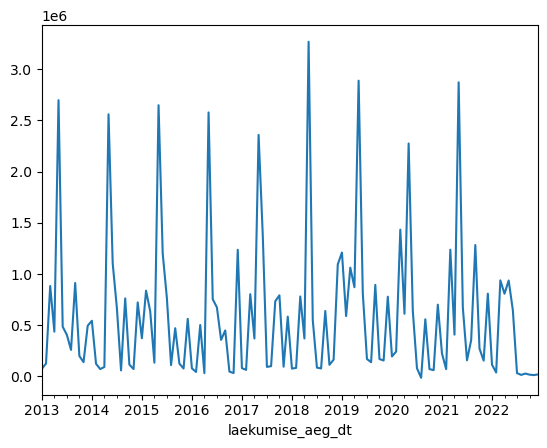

In [14]:
#monthly sums
df.set_index('laekumise_aeg_dt').groupby(pd.Grouper(freq='M'))['summa'].sum().plot()

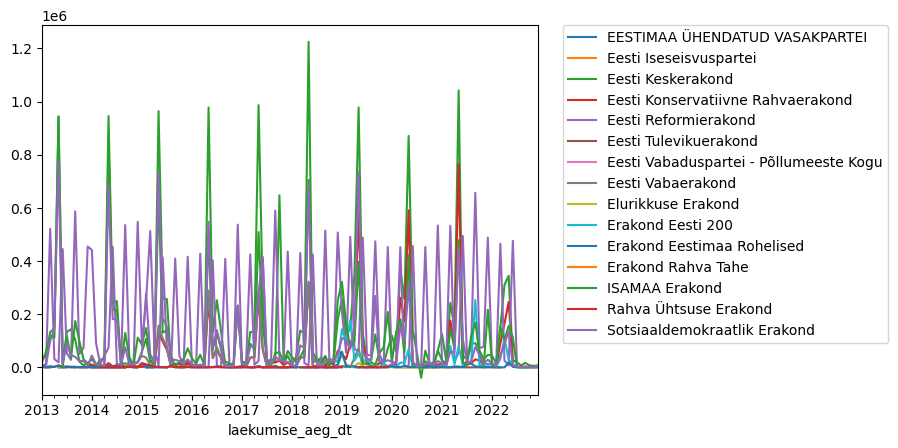

In [22]:
#monthly plus 
df.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='M'), 'erakond'])['summa'].sum().unstack().plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [36]:
df_erakond_m=df.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='M'), 'erakond'])['summa'].sum().unstack().fillna(0)
df_erakond_m['date']=df_erakond_m.index
df_erakond_m_melt=df_erakond_m.melt(id_vars=['date'])

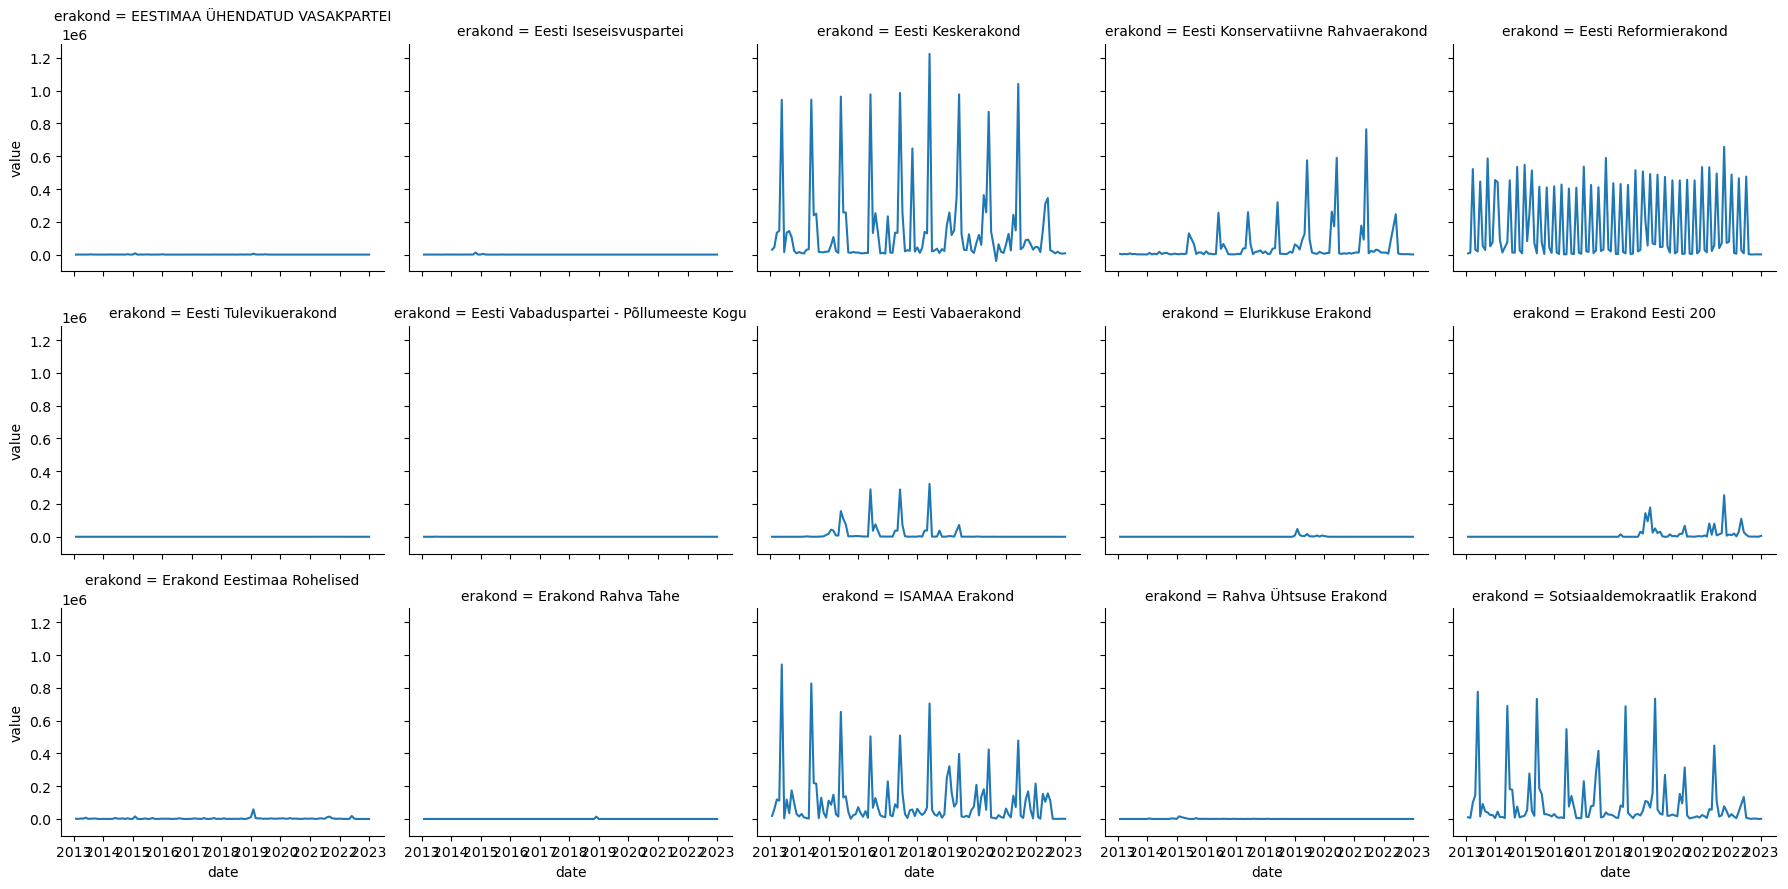

In [46]:
sns.relplot(
    data=df_erakond_m_melt,
    x="date", y="value",
    col="erakond",
    kind="line", col_wrap=5,
    height=3, aspect=1.2, facet_kws=dict(sharex=True),
)

## For further analysis keep partes which have received donations in last year

In [75]:
active_parties=(df[df.laekumise_aeg_dt.dt.year==2022].groupby('erakond')['summa'].sum()>10000)
active_parties=active_parties[active_parties].index
active_parties

Index(['Eesti Keskerakond', 'Eesti Konservatiivne Rahvaerakond',
       'Eesti Reformierakond', 'Erakond Eesti 200',
       'Erakond Eestimaa Rohelised', 'ISAMAA Erakond',
       'Sotsiaaldemokraatlik Erakond'],
      dtype='object', name='erakond')

In [76]:
df_active=df[df.erakond.isin(active_parties)]
df_active.shape

(118288, 9)

In [77]:
df_erakond_active_m=df_active.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='M'), 'erakond'])['summa'].sum().unstack().fillna(0)
df_erakond_active_m['date']=df_erakond_active_m.index
df_erakond_active_m_melt=df_erakond_active_m.melt(id_vars=['date'])

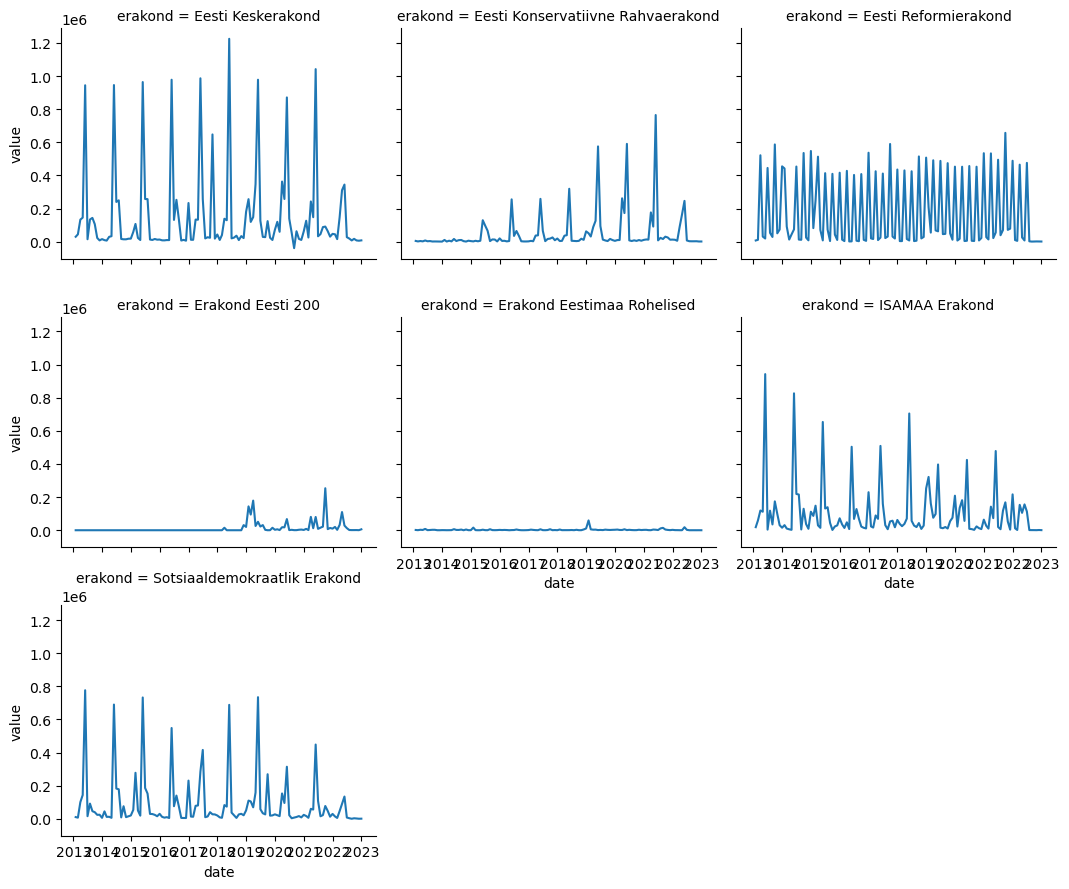

In [78]:
sns.relplot(
    data=df_erakond_active_m_melt,
    x="date", y="value",
    col="erakond",
    kind="line", col_wrap=3,
    height=3, aspect=1.2, facet_kws=dict(sharex=True),
)